# 연구를 위한 Deep Agent 설계(Deep Agent for Research)

이전까지 알아본 모든 내용을 종합하여 Deep Agent를 완성합니다.

**Context Offloading**, **Sub-agent Delegation**, **Strategic Thinking** 을 결합하여 복잡한 리서치 워크플로우를 최적화하는 방법을 다룹니다.

**🏆 핵심 내용**

*   **Deep Agent 아키텍처**: 파일 기반 컨텍스트 관리 및 토큰 효율화
*   **Search Tool**: Tavily API 연동, 웹페이지 요약, 파일 저장
*   **Think Tool**: 리서치 진행 상황 분석 및 전략적 의사결정 도구
*   **Sub-agent**: Research Sub-agent 구성 및 작업 위임

In [1]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Deep-Agent-Tutorial


## Deep Agent 아키텍처 및 도구 설계

![agent_header](./assets/agent_header.png)

**핵심 구조**

*   **TODO List**: 작업 진행 상황 관리
*   **File System**: 원본 데이터 저장 (Context Offloading)
*   **Sub-agent**: 리서치 작업 위임 및 컨텍스트 분리

## 도구(Research)

이 모듈은 리서치 에이전트를 위한 검색 및 콘텐츠 처리 유틸리티 제공.
웹 검색 기능 및 콘텐츠 요약 도구 포함.

### Search Tool 설계

웹 검색 결과를 파일로 저장하고 요약본만 에이전트에게 전달하여 토큰 효율성을 극대화합니다.

*   **`run_tavily_search`**: Tavily API 기반 웹 검색
*   **`summarize_webpage_content`**: gpt 활용 구조적 요약 및 파일명 생성
*   **`process_search_results`**: HTML → Markdown 변환 및 결과 처리
*   **`tavily_search` (Tool)**: 검색-요약-저장 통합 프로세스, 최소 정보 반환
*   **`think_tool`**: 리서치 결과 분석 및 전략적 의사결정 지원

In [2]:
from typing import Literal
from tavily import TavilyClient


tavily_client = TavilyClient()


def run_web_search(
    search_query: str,
    max_results: int = 2,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic,
    )
    return result

In [3]:
result = run_web_search("테디노트 rag 에 대해서 검색해줘")
print(result)

{'query': '테디노트 rag 에 대해서 검색해줘', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://wikidocs.net/book/16865', 'title': '테디노트의 RAG 비법노트 : RAG 시작하기 - WikiDocs - 위키독스', 'content': '[프로젝트] PDF 기반 QA 챗봇 구축하기](javascript:page(265347))   [07 [프로젝트] LangSmith 추적, 다양한 LLM 을 RAG 에 적용하기](javascript:page(265349))   실습 코드)   여기서, 원하는 PDF 빼기(정리하기))   파라미터 생성, 셀렉트 박스 만들기, 랭스미스로 디버깅)   [08. RAG 시작하기(LangChain 랭체인 비법노트)  - 2025년 3월 18일 1:07 오후 [프로젝트] 더 나은 답변을 위한 프롬프트 조정하기(출처, 표)](/265344)  - 2024년 11월 4일 9:44 오후 02 RAG 프로세스 이해하기(실행단계)  - 2024년 10월 31일 9:15 오후 PDF 문서 기반 QA RAG  - 2024년 10월 31일 9:15 오후 [프로젝트] 프롬프트를 개선해주는 프롬프트 메이커](/265348)  - 2024년 10월 31일 9:14 오후 [05 [프로젝트] Page 분할, 파일 업로더 기능 추가하기](/265350)  - 2024년 10월 31일 9:11 오후 [프로젝트] PDF 기반 QA 챗봇 구축하기](/265347)  - 2024년 10월 31일 9:10 오후 실습 코드  - 2024년 10월 31일 8:52 오후', 'score': 0.5172057, 'raw_content': '[**테디노트의 RAG 비법노트 : RAG 시작하기**](/book/16865)   [RAG 시작하기(LangChain 랭체인 비법노트)](javascript:page(265342))   [01. 

In [4]:
result["results"][0]

{'url': 'https://wikidocs.net/book/16865',
 'title': '테디노트의 RAG 비법노트 : RAG 시작하기 - WikiDocs - 위키독스',
 'content': '[프로젝트] PDF 기반 QA 챗봇 구축하기](javascript:page(265347))   [07 [프로젝트] LangSmith 추적, 다양한 LLM 을 RAG 에 적용하기](javascript:page(265349))   실습 코드)   여기서, 원하는 PDF 빼기(정리하기))   파라미터 생성, 셀렉트 박스 만들기, 랭스미스로 디버깅)   [08. RAG 시작하기(LangChain 랭체인 비법노트)  - 2025년 3월 18일 1:07 오후 [프로젝트] 더 나은 답변을 위한 프롬프트 조정하기(출처, 표)](/265344)  - 2024년 11월 4일 9:44 오후 02 RAG 프로세스 이해하기(실행단계)  - 2024년 10월 31일 9:15 오후 PDF 문서 기반 QA RAG  - 2024년 10월 31일 9:15 오후 [프로젝트] 프롬프트를 개선해주는 프롬프트 메이커](/265348)  - 2024년 10월 31일 9:14 오후 [05 [프로젝트] Page 분할, 파일 업로더 기능 추가하기](/265350)  - 2024년 10월 31일 9:11 오후 [프로젝트] PDF 기반 QA 챗봇 구축하기](/265347)  - 2024년 10월 31일 9:10 오후 실습 코드  - 2024년 10월 31일 8:52 오후',
 'score': 0.5172057,
 'raw_content': '[**테디노트의 RAG 비법노트 : RAG 시작하기**](/book/16865)   [RAG 시작하기(LangChain 랭체인 비법노트)](javascript:page(265342))   [01. RAG 프로세스 이해하기(시작단계)](javascript:page(265343))   [02 RAG 프로세스 이해하기(실행단계)](javascript:page(265345))   

In [5]:
from datetime import datetime


def get_current_time() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%b %-d, %Y %H:%M:%S (%A)")

In [6]:
get_current_time()

'Nov 29, 2025 22:40:04 (Saturday)'

## 웹 검색 결과 컨텍스트 최적화를 위한 요약 파이프라인

요약된 결과 형식
- `filename`: 요약된 파일명
- `summary`: 요약된 내용

In [7]:
# 요약 프롬프트
SUMMARIZE_WEB_SEARCH = """You are creating a minimal summary for research steering - your goal is to help an agent know what information it has collected, NOT to preserve all details.

<webpage_content>
{webpage_content}
</webpage_content>

Create a VERY CONCISE summary focusing on:
1. Main topic/subject in 1-2 sentences
2. Key information type (facts, tutorial, news, analysis, etc.)
3. Most significant 1-2 findings or points
4. Write the summary in Korean

Keep the summary under 150 words total. The agent needs to know what's in this file to decide if it should search for more information or use this source.

Generate a descriptive filename that indicates the content type and topic (e.g., "mcp_protocol_overview.md", "ai_safety_research_2024.md").

Output format:
```json
{{
   "filename": "descriptive_filename.md",
   "summary": "Very brief summary under 150 words focusing on main topic and key findings"
}}
```

Today's date: {date}
"""

In [8]:
from langchain_core.messages import HumanMessage, ToolMessage
from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model

# 요약을 위한 LLM 초기화
summarization_model = init_chat_model(
    model="anthropic:claude-haiku-4-5", temperature=0.0
)


class Summary(BaseModel):
    """Schema for webpage content summarization."""

    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")


def summarize_webpage_contents(webpage_contents: list[str]) -> list[Summary]:
    """Summarize multiple webpage contents in parallel using batch processing.

    LangChain의 batch() 메서드를 활용하여 여러 웹페이지 콘텐츠를 병렬로 요약

    Args:
        webpage_contents: List of raw webpage contents to summarize

    Returns:
        List of Summary objects with filename and summary for each content
    """
    if not webpage_contents:
        return []

    # 구조화된 출력 모델 설정
    structured_model = summarization_model.with_structured_output(Summary)

    # 각 콘텐츠에 대한 메시지 리스트 생성 (batch 입력 형식)
    batch_inputs = [
        [
            HumanMessage(
                content=SUMMARIZE_WEB_SEARCH.format(
                    webpage_content=content, date=get_current_time()
                )
            )
        ]
        for content in webpage_contents
    ]

    try:
        # batch() 메서드로 병렬 처리 실행
        summaries = structured_model.batch(batch_inputs)
        return summaries

    except Exception as e:
        # 실패시 기본 요약 객체 리스트 반환
        print(f"Batch processing failed: {e}, falling back to sequential processing")
        return [
            Summary(
                filename=f"search_result_{i}.md",
                summary=(content[:1000] + "..." if len(content) > 1000 else content),
            )
            for i, content in enumerate(webpage_contents)
        ]

In [9]:
# 요약 테스트 결과(2건)
summarize_webpage_contents(result["results"])

[Summary(filename='rag_langchain_tutorial_guide.md', summary='테디노트의 RAG 비법노트는 LangChain을 활용한 RAG(Retrieval-Augmented Generation) 시작 가이드입니다.\n\n**주요 내용:**\n- RAG 프로세스의 기본 개념부터 실무 적용까지 단계별 학습\n- PDF 기반 QA 챗봇 구축 프로젝트 (파일 업로드, 문서 청킹, 검색 등)\n- Streamlit을 이용한 UI 개발, LangSmith 디버깅 도구 활용\n- 프롬프트 최적화 및 다양한 LLM 모델 적용 방법\n\n**특징:**\n유튜브 2만 구독자 설문 기반으로 제작된 초보자 친화적 튜토리얼로, 이론과 실습 코드를 함께 제공합니다. 고급 내용은 유료 강의에서 제공됩니다.'),
 Summary(filename='rag_langchain_implementation_tutorial.md', summary='**주제**: LangChain을 활용한 RAG(Retrieval-Augmented Generation) 구현 튜토리얼\n\n**정보 유형**: 기술 튜토리얼 및 실습 가이드\n\n**핵심 내용**:\n- RAG는 2020년 Facebook AI Research에서 제안한 기법으로, 검색(Retrieval)과 생성(Generation)을 결합하여 LLM의 최신 정보 부족 문제 해결\n- RAG의 8단계 프로세스: 문서 로딩 → 텍스트 분할 → 임베딩 → 벡터 저장 → 검색 → 프롬프트 구성 → LLM 응답 생성 → 체인 연결\n- LangChain 기반 실제 구현 예시: PDF 문서(삼성 가우스 AI 관련)를 활용한 질의응답 시스템으로, RAG 사용 시 정확한 답변 생성 확인\n\n**실용성**: 계약서 요약, 논문 QA, 뉴스 기반 시스템 등 확장 가능')]

In [10]:
def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content in parallel using batch processing.

    LangChain의 batch() 메서드를 활용하여 여러 검색 결과를 병렬로 요약합니다.
    순차 처리 대비 처리 시간을 대폭 단축할 수 있습니다.

    Args:
        results: Tavily search results dictionary

    Returns:
        List of processed results with summaries
    """
    search_results = results.get("results", [])

    if not search_results:
        return []

    # 모든 raw_content를 리스트로 추출 (batch 입력용)
    raw_contents = [result.get("raw_content", "") for result in search_results]

    # batch 방식으로 모든 콘텐츠를 병렬 요약 처리 (summarize_webpage_contents 함수 활용)
    summary_objects = summarize_webpage_contents(raw_contents)

    # 요약 결과와 원본 검색 결과를 결합하여 최종 결과 생성
    processed_results = []
    for result, summary_obj in zip(search_results, summary_objects):
        processed_results.append(
            {
                "url": result["url"],
                "title": result["title"],
                "summary": summary_obj.summary,
                "filename": summary_obj.filename,
                "raw_content": result.get("raw_content", ""),
            }
        )

    return processed_results

In [11]:
process_search_results(result)

[{'url': 'https://wikidocs.net/book/16865',
  'title': '테디노트의 RAG 비법노트 : RAG 시작하기 - WikiDocs - 위키독스',
  'summary': '테디노트의 RAG 비법노트는 LangChain을 활용한 RAG(Retrieval-Augmented Generation) 입문 가이드입니다.\n\n**주요 내용:**\n- RAG 프로세스의 기본 개념부터 실무 적용까지 단계별 학습\n- PDF 문서 기반 QA 시스템 구축 실습\n- Streamlit을 이용한 프롬프트 메이커, 파일 업로더, 챗봇 프로젝트\n- LangSmith를 활용한 디버깅 및 다양한 LLM 적용\n\n**핵심 특징:**\n유튜브 구독자 설문 기반으로 제작된 초보자 친화적 튜토리얼로, 기본 원리 이해와 실습 프로젝트를 병행합니다. 고급 내용은 유료 강의에서 제공됩니다.',
  'filename': 'rag_langchain_tutorial_guide.md',
  'raw_content': '[**테디노트의 RAG 비법노트 : RAG 시작하기**](/book/16865)   [RAG 시작하기(LangChain 랭체인 비법노트)](javascript:page(265342))   [01. RAG 프로세스 이해하기(시작단계)](javascript:page(265343))   [02 RAG 프로세스 이해하기(실행단계)](javascript:page(265345))   [03. PDF 문서 기반 QA RAG](javascript:page(265346))   [실습 코드](javascript:page(265456))   [04. [프로젝트] 프롬프트를 개선해주는 프롬프트 메이커](javascript:page(265348))   [05 [프로젝트] Page 분할, 파일 업로더 기능 추가하기](javascript:page(265350))   [06. [프로젝트] PDF 기반 QA 챗봇 구축하기](javascript:page(265347))   [07 [프로

In [12]:
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from typing_extensions import Annotated, Literal
from deep_agents_from_scratch.state import DeepAgentState


@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[
        Literal["general", "news", "finance"], InjectedToolArg
    ] = "general",
) -> Command:
    """웹 검색을 수행하고 상세한 결과를 파일에 저장하면서 최소한의 컨텍스트만 반환합니다.

    웹 검색을 수행하고 전체 콘텐츠를 파일에 저장하여 컨텍스트 오프로딩을 수행합니다.
    에이전트가 다음 단계를 결정하는 데 도움이 되는 필수 정보만 반환합니다.

    Args:
        query: 실행할 검색 쿼리
        state: 파일 저장을 위한 주입된 에이전트 상태
        tool_call_id: 주입된 도구 호출 식별자
        max_results: 반환할 최대 결과 수 (기본값: 1)
        topic: 토픽 필터 - 'general', 'news', 또는 'finance' (기본값: 'general')

    Returns:
        전체 결과를 파일에 저장하고 최소한의 요약을 제공하는 Command
    """
    # 검색 실행
    search_results = run_web_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # 결과 처리 및 요약
    processed_results = process_search_results(search_results)

    # 각 결과를 파일에 저장하고 요약 준비
    files = state.get("files", {})
    saved_files = []
    summaries = []

    for i, result in enumerate(processed_results):
        # 요약에서 AI가 생성한 파일명 사용
        filename = result["filename"]

        # 전체 상세 정보를 포함한 파일 콘텐츠 생성
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_current_time()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""

        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")

    # 도구 메시지를 위한 최소한의 요약 생성 - 수집된 내용에 집중
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [ToolMessage(summary_text, tool_call_id=tool_call_id)],
        }
    )

In [13]:
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

## Deep Agent 구성

리서치 에이전트의 전체 구조를 조립합니다.

*   **Research Sub-agent**: `tavily_search`, `think_tool` 할당 → 정보 탐색 및 분석 집중
*   **Parent Agent**: `task`(위임), `think_tool`, 파일 시스템 도구 할당 → 전체 조율 및 관리
*   **효과**: 명확한 역할 분리를 통한 복잡한 워크플로우의 체계적 관리

In [14]:
from datetime import datetime

from IPython.display import display
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)

from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# LLM 객체 초기화
model = init_chat_model(model="anthropic:claude-sonnet-4-5", temperature=0.0)

# 리서치 서브에이전트 동시 실행 최대 개수 및 반복 횟수 제한 설정
max_concurrent_research_units = 3
max_researcher_iterations = 3

# 리서치 서브에이전트에 할당할 도구 리스트 (웹 검색 및 전략적 사고 도구)
sub_agent_tools = [tavily_search, think_tool]
# 메인 에이전트에 할당할 파일 시스템 및 TODO 관리 도구, 전략적 사고 도구 포함
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# 리서치 서브에이전트 구성 정보 (이름, 설명, 프롬프트, 도구 목록)
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_current_time()),
    "tools": ["tavily_search", "think_tool"],
}

# 서브에이전트에게 작업 위임을 위한 Task Tool 생성 (모델, 상태, 도구 전달)
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# 메인 에이전트에 위임 도구 포함 전체 도구 리스트 생성 (검색 도구 직접 사용 가능)
delegation_tools = [task_tool]
all_tools = (
    sub_agent_tools + built_in_tools + delegation_tools
)  # search available to main agent for trivial cases

# 서브에이전트 프롬프트 생성 (최대 동시 리서치 개수, 반복 횟수, 날짜 포함)
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [15]:
# 리서처 에이전트 프롬프트 출력
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [16]:
# TODO 관리, 파일 시스템 사용, 서브에이전트 위임 관련 프롬프트를 하나의 문자열로 통합
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

# 통합된 프롬프트를 화면에 출력하여 에이전트의 역할 및 사용법 안내
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

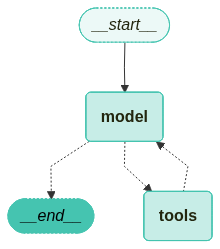

In [17]:
from langchain_teddynote.graphs import visualize_graph

# Deep Agent 생성 및 설정
agent = create_agent(
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 에이전트 시각화
visualize_graph(agent)

In [18]:
from utils import format_messages

# 에이전트에게 MCP 개요 요청 메시지 전달 및 응답 결과 저장
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

# 에이전트 응답 메시지 포맷팅 및 출력, 사용자 친화적 결과 확인 목적
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the Model Context Protocol (MCP). Let me start by setting up a research plan and         │
│ delegating this task.                                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Delegate research on Model Context Protocol (MCP) to sub-agent",                              │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Review research findings and provide comprehensive overview to user",                         │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Rd4bRATNw6f72LX4qPjwra                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01LZSVyUgEd8TYTqnKsTKxc5                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Delegate research on Model Context Protocol (MCP) to sub-agent', 'status':   │
│ 'in_progress'}, {'content': 'Review research findings and provide comprehensive overview to user', 'status':    │
│ 'pending'}]                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research the Model Context Protocol (MCP). Find information about: what MCP is, its purpose   │
│ and goals, key features and capabilities, how it works, who developed it, use cases and applications, and its   │
│ significance in the AI/LLM ecosystem."                                                                          │
│ }                                                                                                               │
│    ID: toolu_01HHtoyKmHVc9YCjJBKodysL                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open standard protocol that enables AI applications to communicate   │
│ efficiently with external services, tools, databases, and data sources. Think of it as a "USB port for AI" - a  │
│ standardized connection layer that allows LLMs to plug into various external resources seamlessly.              │
│                                                                                                                 │
│ ## Developer & Timeline                                                                                         │
│                                                                                                                 │
│ **Developed by Anthropic in 2024**, MCP was introduced as an open standard to address the fragmentation in      │
│ AI-tool integration.                                                                                            │
│                                                                                                                 │
│ ## Purpose & Goals                                                                                              │
│                                                                                                                 │
│ MCP aims to:                                                                                                    │
│ - **Standardize integration** between LLMs and external tools/data sources                                      │
│ - **Enable "plug and play" connectivity** for AI applications                                                   │
│ - **Reduce development overhead** and maintenance burden for tool integrations                                  │
│ - **Facilitate interoperability** across different AI systems and platforms                                     │
│ - **Improve information sharing** between multi-agent systems                                                   │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ MCP uses a **JSON-RPC based client-server architecture** with three core components:                            │
│                                                                                                                 │
│ 1. **Host**: The AI application (e.g., Claude Desktop, IDEs)                                                    │
│ 2. **Client**: Translates and manages requests between the host and servers                                     │
│ 3. **Server**: External services that provide tools, data, or resources                                         │
│                                                                                                                 │
│ **Important distinction**: MCP is an integration layer, NOT an agent framework. It works complementarily with   │
│ frameworks like LangChain and LangGraph.                                                                        │
│                                                                                                                 │
│ ## Key Features & Capabilities                         

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research sub-agent has provided comprehensive information about the Model Context Protocol │
│ (MCP). The findings cover all the key aspects I would need to provide a thorough overview:\n\n1. ✓ What MCP is  │
│ - a standardized protocol for AI-tool integration\n2. ✓ Who developed it - Anthropic in 2024\n3. ✓ Purpose and  │
│ goals - standardization, interoperability, reducing development overhead\n4. ✓ Technical architecture -         │
│ JSON-RPC based client-server model\n5. ✓ Key features - bidirectional communication, security, resource         │
│ management\n6. ✓ How it works - standardized communication layer\n7. ✓ Use cases - enterprise applications,     │
│ data assistants, IDE integration\n8. ✓ Significance - emerging standard, efficiency gains, solving              │
│ fragmentation\n9. ✓ Current challenges and adoption status\n\nThe information is well-structured,               │
│ comprehensive, and includes specific examples and metrics. I have sufficient information to provide a complete  │
│ overview to the user. No additional research is needed."                                                        │
│ }                                                                                                               │
│    ID: toolu_01Qcy6YBGG8m1Jhp6yzmReA2                                                                           │
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01QNmteXiMsmg1rcbGLTNBNf                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research sub-agent has provided comprehensive information about the Model Context      │
│ Protocol (MCP). The findings cover all the key aspects I would need to provide a thorough overview:             │
│                                                                                                                 │
│ 1. ✓ What MCP is - a standardized protocol for AI-tool integration                                              │
│ 2. ✓ Who developed it - Anthropic in 2024                                                                       │
│ 3. ✓ Purpose and goals - standardization, interoperability, reducing development overhead                       │
│ 4. ✓ Technical architecture - JSON-RPC based client-server model                                                │
│ 5. ✓ Key features - bidirectional communication, security, resource management                                  │
│ 6. ✓ How it works - standardized communication layer                                                            │
│ 7. ✓ Use cases - enterprise applications, data assistants, IDE integration                                      │
│ 8. ✓ Significance - emerging standard, efficiency gains, solving fragmentation                                  │
│ 9. ✓ Current challenges and adoption status                                                                     │
│                                                                                                                 │
│ The information is well-structured, comprehensive, and includes specific examples and metrics. I have           │
│ sufficient information to provide a complete overview to the user. No additional research is needed.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. 🔄 Delegate research on Model Context Protocol (MCP) to sub-agent (in_progress)                              │
│ 2. ⏳ Review research findings and provide comprehensive overview to user (pending)                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Delegate research on Model Context Protocol (MCP) to sub-agent",                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Review research findings and provide comprehensive overview to user",                         │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01WLCnHPi2FpfXEb6aP2ibQ6                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Delegate research on Model Context Protocol (MCP) to sub-agent', 'status':   │
│ 'completed'}, {'content': 'Review research findings and provide comprehensive overview to user', 'status':      │
│ 'completed'}]                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Overview of Model Context Protocol (MCP)                                                                      │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open standard protocol developed by **Anthropic in 2024** that       │
│ enables AI applications to communicate efficiently with external services, tools, databases, and data sources.  │
│ It's often described as a **"USB port for AI"** - providing a standardized connection layer that allows large   │
│ language models (LLMs) to plug into various external resources seamlessly.                                      │
│                                                                                                                 │
│ ## Core Purpose                                                                                                 │
│                                                                                                                 │
│ MCP addresses a critical challenge in the AI ecosystem: the fragmentation of tool integrations. Before MCP,     │
│ each AI application needed custom integrations for every tool or data source, creating significant development  │
│ overhead. MCP standardizes this process, enabling:                                                              │
│                                                                                                                 │
│ - **Plug-and-play connectivity** for AI applications                                                            │
│ - **Reduced development and maintenance burden**                                                                │
│ - **Improved interoperability** across different AI systems                                                     │
│ - **Efficient information sharing** between multi-agent systems                                                 │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ MCP uses a **JSON-RPC based client-server architecture** with three core components:                            │
│                                                                                                                 │
│ 1. **Host**: The AI application (e.g., Claude Desktop, IDEs)                                                    │
│ 2. **Client**: Translates and manages requests between the host and servers                                     │
│ 3. **Server**: External services that provide tools, data, or resources                                         │
│                                                                                                                 │
│ **Important Note**: MCP is an integration layer, NOT an agent framework. It works complementarily with existing │
│ frameworks like LangChain and LangGraph.                                                                        │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ - **Bidirectional Communication**: Two-way data flow be

## 실행 결과 트레이스 (LangSmith)

Deep Agent의 실제 실행 흐름, 검색/요약 처리, 파일 저장 과정을 시각적으로 확인합니다.

*   [실행 트레이스 예시 보기](https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r)